### LLM Hallucination Detection via Semantic Entropy & Embedding Geometry

**Based on:** Farquhar et al. (2024) · Ricco et al. (2025) · Lee et al. (2018)  
**Dataset:** [MMLU](https://huggingface.co/datasets/cais/mmlu)  
**Runtime:** Google Colab (free tier, T4 GPU recommended)

## Install Dependencies

In [ ]:
# !pip install -q datasets transformers sentence-transformers \
#              scikit-learn xgboost scipy umap-learn shap \
#              matplotlib seaborn accelerate

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from datasets import load_dataset
from transformers import T5ForConditionalGeneration, T5Tokenizer
from sentence_transformers import SentenceTransformer
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve
from scipy.stats import ks_2samp
import xgboost as xgb
import shap
import torch

print(f"PyTorch device: {'cuda' if torch.cuda.is_available() else 'cpu'}")
print("All imports successful")

PyTorch device: cpu
All imports successful


## Configuration

> **Tip:** Change `mmlu_subject` to any MMLU topic (e.g. `"world_history"`, `"high_school_physics"`).  
> Increase `n_questions` to 200 for better statistics.

In [2]:
CONFIG = {
    "dataset_name"   : "cais/mmlu",
    "mmlu_subject"   : "high_school_geography",  # ← change subject here
    "n_questions"    : 200,       # increase to 500 for better statistics
    "n_samples"      : 100,        # responses per question (N in the paper)
    "temperature"    : 0.5,       # higher = more diverse answers
    "sim_threshold"  : 0.85,      # cosine similarity threshold for clustering
    "generator_model": "google/flan-t5-base",    # free, runs on T4
    "embedding_model": "all-MiniLM-L6-v2",       # fast 384-dim embeddings
    "random_seed"    : 42,
}

np.random.seed(CONFIG["random_seed"])
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
ANSWER_MAP = {0: "A", 1: "B", 2: "C", 3: "D"}
print(f"Running on: {DEVICE}")

Running on: cpu


## Load MMLU Dataset

In [3]:
print(f"Loading MMLU — subject: {CONFIG['mmlu_subject']} ...")
dataset = load_dataset(CONFIG["dataset_name"], CONFIG["mmlu_subject"], split="test")

n = min(CONFIG["n_questions"], len(dataset))
indices = np.random.choice(len(dataset), n, replace=False)
questions_raw = [dataset[int(i)] for i in indices]

print(f"Loaded {n} questions")
print("\nExample question:")
ex = questions_raw[0]
print(f"  Q: {ex['question']}")
for i, c in enumerate(ex['choices']):
    print(f"  {ANSWER_MAP[i]}) {c}")
print(f"  ✔ Correct answer: {ANSWER_MAP[ex['answer']]}")

Loading MMLU — subject: high_school_geography ...
Loaded 198 questions

Example question:
  Q: The concentration of production activities and people spatially to benefit everyone is called
  A) the substitution principle.
  B) deglomeration.
  C) agglomeration.
  D) infrastructure.
  ✔ Correct answer: C


## Benchmark the LLM (20 samples per question)

We use **Flan-T5-Base** as the generator.  
Each question is asked **N=20 times** with nucleus sampling to get a distribution of answers.  

In [4]:
print(f"Loading generator: {CONFIG['generator_model']} ...")
tokenizer = T5Tokenizer.from_pretrained(CONFIG["generator_model"])
generator = T5ForConditionalGeneration.from_pretrained(CONFIG["generator_model"]).to(DEVICE)
generator.eval()
print("Generator loaded")

def build_prompt(item):
    choices = item["choices"]
    return (
        f"Answer the following multiple choice question. "
        f"Respond with only the letter A, B, C, or D.\n\n"
        f"Question: {item['question']}\n"
        f"A) {choices[0]}\nB) {choices[1]}\nC) {choices[2]}\nD) {choices[3]}\nAnswer:"
    )

def sample_responses(item, n_samples, temperature):
    prompt = build_prompt(item)
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512).to(DEVICE)
    with torch.no_grad():
        outputs = generator.generate(
            **inputs,
            max_new_tokens=10,
            do_sample=True,
            temperature=temperature,
            top_p=0.95,
            num_return_sequences=n_samples,
        )
    return [tokenizer.decode(o, skip_special_tokens=True).strip() for o in outputs]

print(f"\nSampling {CONFIG['n_samples']} responses × {n} questions ...")

all_responses = []
for idx, item in enumerate(questions_raw):
    responses = sample_responses(item, CONFIG["n_samples"], CONFIG["temperature"])
    all_responses.append(responses)
    if (idx + 1) % 10 == 0:
        print(f"   [{idx+1}/{n}] done")

print(f"   Sample responses for Q1: {all_responses[0][:4]}")

Loading generator: google/flan-t5-base ...


Loading weights:   0%|          | 0/282 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie shared.weight to lm_head.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning


Generator loaded

Sampling 100 responses × 198 questions ...
   [10/198] done
   [20/198] done
   [30/198] done
   [40/198] done
   [50/198] done
   [60/198] done
   [70/198] done
   [80/198] done
   [90/198] done
   [100/198] done
   [110/198] done
   [120/198] done
   [130/198] done
   [140/198] done
   [150/198] done
   [160/198] done
   [170/198] done
   [180/198] done
   [190/198] done
   Sample responses for Q1: ['B', 'B', 'B', 'B']


## Label Responses

Since MMLU is **multiple-choice**, we use **exact letter matching** instead of an LLM judge —  
cheaper, faster, and equally accurate for this task.

Question-level label = **majority vote** over the 20 responses.

In [5]:
def extract_answer_letter(response_text):
    for char in response_text.upper().strip():
        if char in ("A", "B", "C", "D"):
            return char
    return None

def label_responses(item, responses):
    correct = ANSWER_MAP[item["answer"]]
    labels = [0 if extract_answer_letter(r) == correct else 1 for r in responses]
    hall_rate = np.mean(labels)
    return labels, hall_rate, int(hall_rate > 0.5)

response_labels, hallucination_rates, question_labels = [], [], []

for item, responses in zip(questions_raw, all_responses):
    labels, hall_rate, q_label = label_responses(item, responses)
    response_labels.append(labels)
    hallucination_rates.append(hall_rate)
    question_labels.append(q_label)

y = np.array(question_labels)

print(f"\n   Correct questions     : {(y==0).sum()} ({(y==0).mean()*100:.1f}%)")
print(f"   Hallucinated questions: {(y==1).sum()} ({(y==1).mean()*100:.1f}%)")
print(f"   Mean hallucination rate: {np.mean(hallucination_rates)*100:.1f}%")


   Correct questions     : 77 (38.9%)
   Hallucinated questions: 121 (61.1%)
   Mean hallucination rate: 59.3%


## Embedding & Feature Extraction

Each question's 20 responses are compressed into **5 scalar features**:

| # | Feature | What it measures |
|---|---------|------------------|
| 1 | `H_sem` | Semantic entropy — diversity of meanings |
| 2 | `D_cos` | Centroid cosine dispersion |
| 3 | `M_bar` | Mean Mahalanobis distance from "correct" region |
| 4 | `K`     | Number of semantic clusters |
| 5 | `σ²_S`  | Variance of pairwise cosine similarities |

In [6]:
print(f"Loading embedding model: {CONFIG['embedding_model']} ...")
embedder = SentenceTransformer(CONFIG["embedding_model"])
print("Embedding model loaded")

# Step A: Embed all responses
print("\nEmbedding all responses ...")
all_embeddings = []
for responses in all_responses:
    embs = embedder.encode(responses, normalize_embeddings=True, show_progress_bar=False)
    all_embeddings.append(embs)  # shape: (N, 384)

# Fit Mahalanobis reference distribution on correct-labelled responses
print("Fitting Mahalanobis reference distribution ...")
correct_embs = np.array([
    emb for embs, labels in zip(all_embeddings, response_labels)
    for emb, lbl in zip(embs, labels) if lbl == 0
])
mu_ref  = correct_embs.mean(axis=0)
cov_ref = np.cov(correct_embs.T) + np.eye(correct_embs.shape[1]) * 1e-6
cov_inv = np.linalg.pinv(cov_ref)
print(f"   Reference fitted on {len(correct_embs)} correct responses")

Loading embedding model: all-MiniLM-L6-v2 ...


Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Embedding model loaded

Embedding all responses ...
Fitting Mahalanobis reference distribution ...
   Reference fitted on 8049 correct responses


In [7]:
def semantic_entropy(embs, threshold=CONFIG["sim_threshold"]):
    N = len(embs)
    dist_matrix = np.clip(1 - cosine_similarity(embs), 0, None)
    np.fill_diagonal(dist_matrix, 0)
    clustering = AgglomerativeClustering(
        n_clusters=None, metric="precomputed",
        linkage="average", distance_threshold=1 - threshold
    )
    ids = clustering.fit_predict(dist_matrix)
    _, counts = np.unique(ids, return_counts=True)
    probs = counts / N
    H = -np.sum(probs * np.log2(probs + 1e-12))
    return H, len(counts)

def cosine_dispersion(embs):
    centroid = embs.mean(axis=0, keepdims=True)
    return np.mean(1 - cosine_similarity(embs, centroid).flatten())

def mahalanobis_distance(embs, mu, cov_inv):
    diffs = embs - mu
    return np.mean(np.sqrt(np.einsum("ni,ij,nj->n", diffs, cov_inv, diffs)))

def similarity_variance(embs):
    sim = cosine_similarity(embs)
    upper = sim[np.triu_indices(len(embs), k=1)]
    return np.var(upper)

# Compute all 5 features for each question
print("Extracting features ...")
features = []
for embs in all_embeddings:
    H, K = semantic_entropy(embs)
    D    = cosine_dispersion(embs)
    M    = mahalanobis_distance(embs, mu_ref, cov_inv)
    sig2 = similarity_variance(embs)
    features.append([H, D, M, K, sig2])

X = np.array(features)
feature_names = ["H_sem", "D_cos", "M_bar", "K", "sig2_S"]

print(f"Feature matrix shape: {X.shape}")

df = pd.DataFrame(X, columns=feature_names)
df["label"] = y

print("\nMean feature values by label:")
display(df.groupby("label")[feature_names].mean().round(3)
          .rename(index={0: "Correct", 1: "Hallucinated"}))

Extracting features ...
Feature matrix shape: (198, 5)

Mean feature values by label:


,H_sem,D_cos,M_bar,K,sig2_S
label,,,,,
Correct,0.508,0.037,1.688,1.974,0.016
Hallucinated,0.885,0.065,1.799,2.570,0.023


## Analysis

### KDE Plots — Feature Distributions by Label

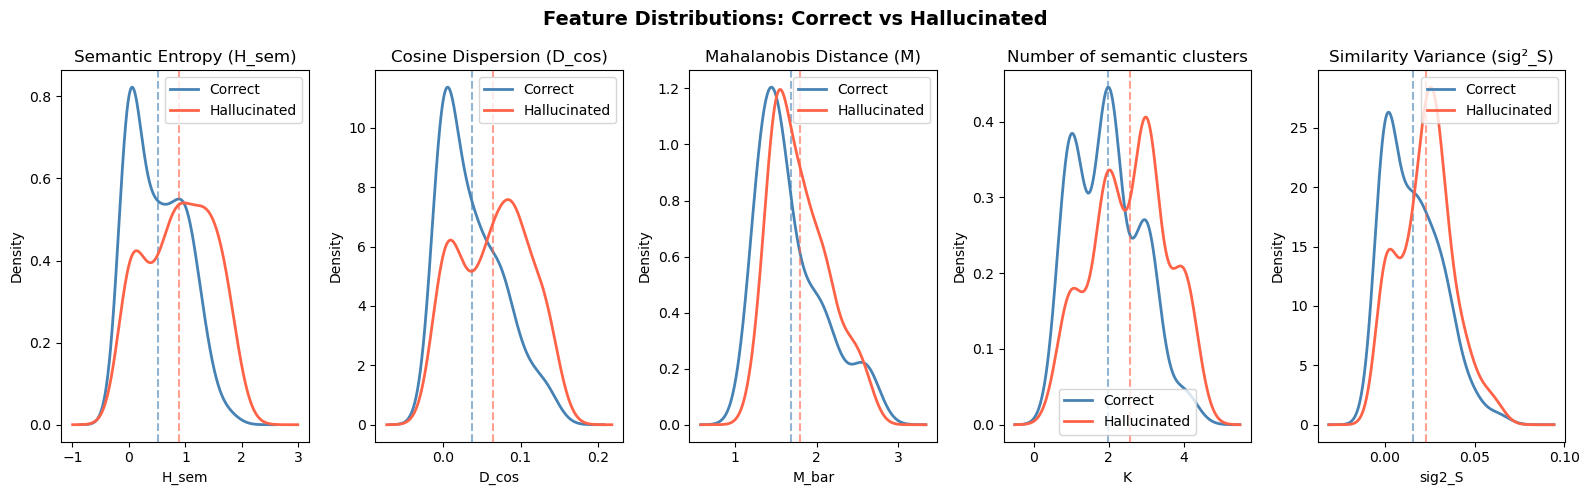

In [8]:
fig, axes = plt.subplots(1, 5, figsize=(16, 5))
fig.suptitle("Feature Distributions: Correct vs Hallucinated", fontsize=14, fontweight="bold")

plot_cols  = ["H_sem", "D_cos", "M_bar", "K", "sig2_S"]
plot_titles = ["Semantic Entropy (H_sem)", "Cosine Dispersion (D_cos)", "Mahalanobis Distance (M̄)", "Number of semantic clusters", "Similarity Variance (sig²_S)"]

for ax, col, title in zip(axes, plot_cols, plot_titles):
    for lbl, color, name in [(0, "steelblue", "Correct"), (1, "tomato", "Hallucinated")]:
        subset = df[df.label == lbl][col]
        subset.plot.kde(ax=ax, color=color, label=name, linewidth=2)
        ax.axvline(subset.mean(), color=color, linestyle="--", alpha=0.6)
    ax.set_title(title)
    ax.legend()
    ax.set_xlabel(col)

plt.tight_layout()
plt.show()

### Feature Correlation Heatmap

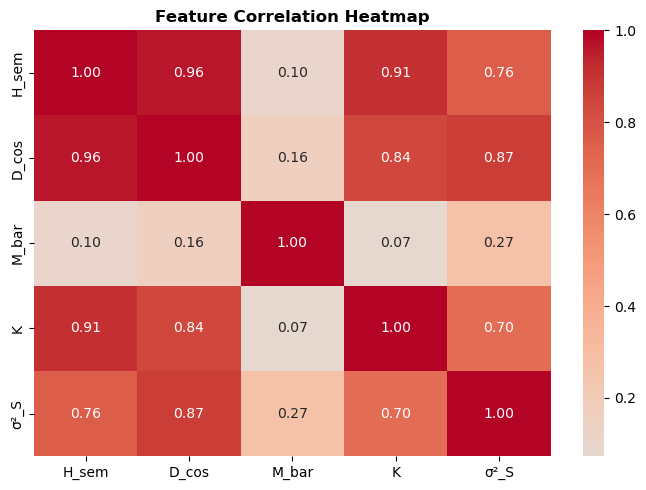

In [9]:
plt.figure(figsize=(7, 5))
corr = df.drop("label", axis=1).corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0,
            xticklabels=["H_sem","D_cos","M_bar","K","σ²_S"],
            yticklabels=["H_sem","D_cos","M_bar","K","σ²_S"])
plt.title("Feature Correlation Heatmap", fontweight="bold")
plt.tight_layout()
plt.show()

### Two-Sample Kolmogorov-Smirnov Test

Tests whether each feature's distribution **differs significantly** between correct and hallucinated questions.  
Bonferroni correction applied: `α_adj = 0.05 / 5 = 0.01`.

In [10]:
print("=" * 55)
print("KS Test Results (Bonferroni α = 0.01)")
print("=" * 55)

alpha_bonf = 0.05 / 5
for col in feature_names:
    g0 = df[df.label==0][col]
    g1 = df[df.label==1][col]
    stat, p = ks_2samp(g0, g1)
    sig = "SIGNIFICANT" if p < alpha_bonf else "not significant"
    print(f"  {col:10s} | KS={stat:.3f} | p={p:.4f} | {sig}")

KS Test Results (Bonferroni α = 0.01)
  H_sem      | KS=0.298 | p=0.0004 | SIGNIFICANT
  D_cos      | KS=0.336 | p=0.0000 | SIGNIFICANT
  M_bar      | KS=0.260 | p=0.0028 | SIGNIFICANT
  K          | KS=0.273 | p=0.0014 | SIGNIFICANT
  sig2_S     | KS=0.299 | p=0.0003 | SIGNIFICANT


### Permutation Test on Mean Entropy Difference

Observed Δ(entropy) = 0.3773 bits
Permutation p-value  = 0.0000
Result: Significant


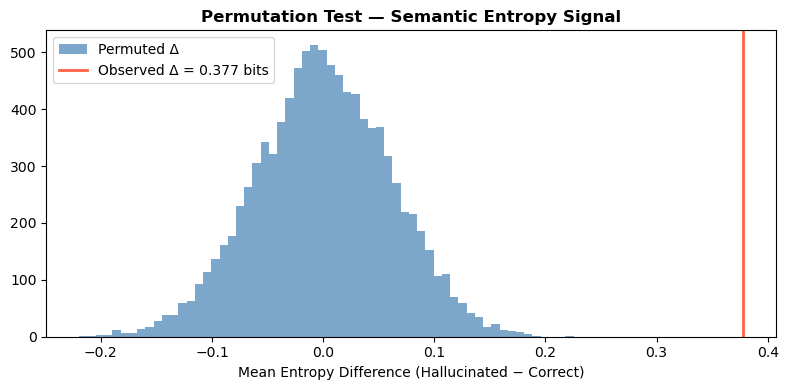

In [11]:
H_vals = df["H_sem"].values
delta_obs = H_vals[y==1].mean() - H_vals[y==0].mean()
print(f"Observed Δ(entropy) = {delta_obs:.4f} bits")

rng = np.random.default_rng(CONFIG["random_seed"])
delta_perm = np.array([
    H_vals[rng.permutation(y)==1].mean() - H_vals[rng.permutation(y)==0].mean()
    for _ in range(10_000)
])

p_perm = np.mean(delta_perm >= delta_obs)
print(f"Permutation p-value  = {p_perm:.4f}")
print(f"Result: {'Significant' if p_perm < 0.05 else 'Not significant'}")

plt.figure(figsize=(8, 4))
plt.hist(delta_perm, bins=60, color="steelblue", alpha=0.7, label="Permuted Δ")
plt.axvline(delta_obs, color="tomato", linewidth=2, label=f"Observed Δ = {delta_obs:.3f} bits")
plt.xlabel("Mean Entropy Difference (Hallucinated − Correct)")
plt.title("Permutation Test — Semantic Entropy Signal", fontweight="bold")
plt.legend()
plt.tight_layout()
plt.show()

### Classification & Ablation Study

Three feature subsets tested against three classifiers — directly comparing
**entropy-only** vs **geometry-only** vs **all features**.

In [12]:
scaler   = StandardScaler()
X_scaled = scaler.fit_transform(X)

feature_subsets = {
    "Entropy only"  : [0],
    "Geometry only" : [1, 2],
    "All features"  : [0, 1, 2, 3, 4],
}

classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=CONFIG["random_seed"]),
    "Random Forest"      : RandomForestClassifier(n_estimators=200, random_state=CONFIG["random_seed"]),
    "XGBoost"            : xgb.XGBClassifier(n_estimators=200, eval_metric="logloss",
                                              random_state=CONFIG["random_seed"], verbosity=0),
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=CONFIG["random_seed"])
results = []

for subset_name, feat_idx in feature_subsets.items():
    X_sub = X_scaled[:, feat_idx]
    for clf_name, clf in classifiers.items():
        scores = cross_val_score(clf, X_sub, y, cv=cv, scoring="roc_auc")
        results.append({"Feature Set": subset_name, "Classifier": clf_name,
                        "AUC Mean": scores.mean(), "AUC Std": scores.std()})

df_results = pd.DataFrame(results)
pivot = df_results.pivot_table(index="Feature Set", columns="Classifier", values="AUC Mean").round(3)
print("5-fold CV AUC-ROC (higher is better):\n")
display(pivot)

5-fold CV AUC-ROC (higher is better):



Classifier,Logistic Regression,Random Forest,XGBoost
Feature Set,,,
All features,0.674,0.663,0.626
Entropy only,0.669,0.589,0.614
Geometry only,0.675,0.602,0.612


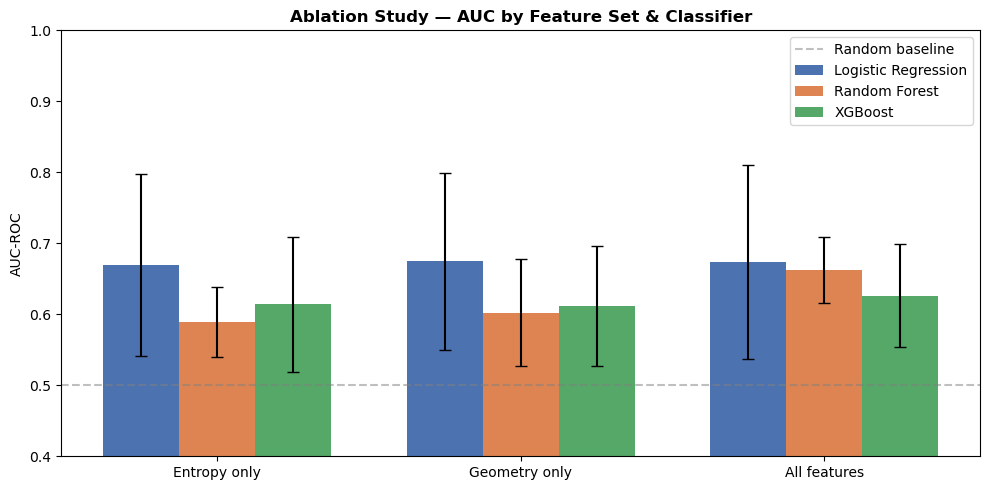

In [13]:
fig, ax = plt.subplots(figsize=(10, 5))
x       = np.arange(len(feature_subsets))
width   = 0.25
colors  = ["#4C72B0", "#DD8452", "#55A868"]

for i, (clf_name, color) in enumerate(zip(classifiers, colors)):
    aucs = [df_results[(df_results["Feature Set"]==fs) & (df_results["Classifier"]==clf_name)]["AUC Mean"].values[0]
            for fs in feature_subsets]
    stds = [df_results[(df_results["Feature Set"]==fs) & (df_results["Classifier"]==clf_name)]["AUC Std"].values[0]
            for fs in feature_subsets]
    ax.bar(x + i*width, aucs, width, label=clf_name, color=color, yerr=stds, capsize=4)

ax.set_xticks(x + width)
ax.set_xticklabels(list(feature_subsets.keys()))
ax.set_ylabel("AUC-ROC")
ax.set_ylim(0.4, 1.0)
ax.axhline(0.5, color="gray", linestyle="--", alpha=0.5, label="Random baseline")
ax.set_title("Ablation Study — AUC by Feature Set & Classifier", fontweight="bold")
ax.legend()
plt.tight_layout()
plt.show()

### Bootstrap 95% Confidence Interval for AUC-ROC

In [14]:
best_clf = RandomForestClassifier(n_estimators=200, random_state=CONFIG["random_seed"])
best_clf.fit(X_scaled, y)

auc_boot = []
rng = np.random.default_rng(CONFIG["random_seed"])
for _ in range(5_000):
    idx = rng.choice(len(y), len(y), replace=True)
    oob = np.setdiff1d(np.arange(len(y)), idx)
    if len(np.unique(y[oob])) < 2:
        continue
    clf_b = RandomForestClassifier(n_estimators=50, random_state=0)
    clf_b.fit(X_scaled[idx], y[idx])
    proba = clf_b.predict_proba(X_scaled[oob])[:, 1]
    auc_boot.append(roc_auc_score(y[oob], proba))

ci_lo, ci_hi = np.percentile(auc_boot, [2.5, 97.5])
print(f"Bootstrap AUC = {np.mean(auc_boot):.3f}  |  95% CI: [{ci_lo:.3f}, {ci_hi:.3f}]")

Bootstrap AUC = 0.654  |  95% CI: [0.545, 0.759]


### ROC Curves — Univariate Feature Performance

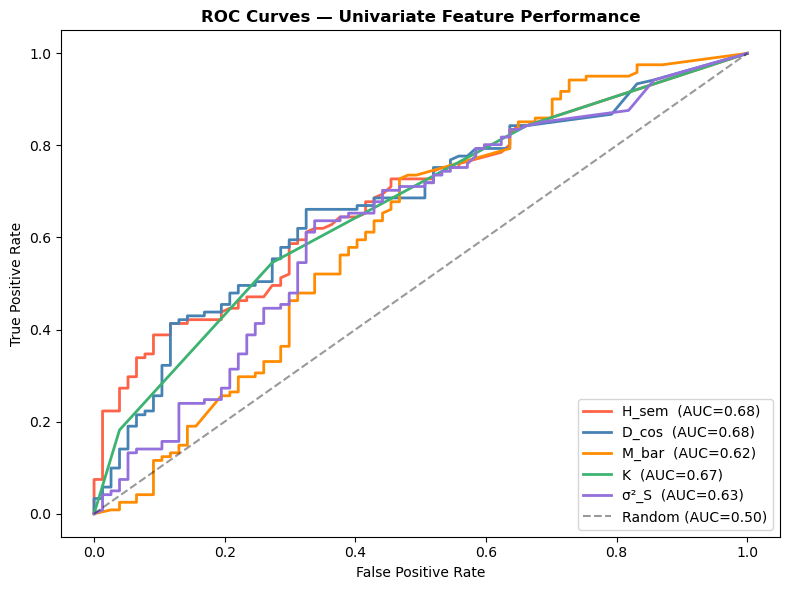

In [15]:
fig, ax = plt.subplots(figsize=(8, 6))
colors_roc = ["tomato", "steelblue", "darkorange", "mediumseagreen", "mediumpurple"]
labels_roc = ["H_sem", "D_cos", "M_bar", "K", "σ²_S"]

for i, (fname, color) in enumerate(zip(labels_roc, colors_roc)):
    fpr, tpr, _ = roc_curve(y, X_scaled[:, i])
    auc = roc_auc_score(y, X_scaled[:, i])
    ax.plot(fpr, tpr, color=color, lw=2, label=f"{fname}  (AUC={auc:.2f})")

ax.plot([0,1],[0,1],"k--", alpha=0.4, label="Random (AUC=0.50)")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC Curves — Univariate Feature Performance", fontweight="bold")
ax.legend(loc="lower right")
plt.tight_layout()
plt.show()

### SHAP Feature Importance

In [42]:
# explainer   = shap.TreeExplainer(best_clf)
# shap_values = explainer.shap_values(X_scaled)
# sv = shap_values[1] if isinstance(shap_values, list) else shap_values

# shap.summary_plot(
#     sv, X_scaled,
#     feature_names=["H_sem", "D_cos", "M_bar", "K", "σ²_S"],
#     show=False
# )
# plt.title("SHAP Beeswarm — Feature Importance", fontweight="bold")
# plt.tight_layout()
# plt.show()

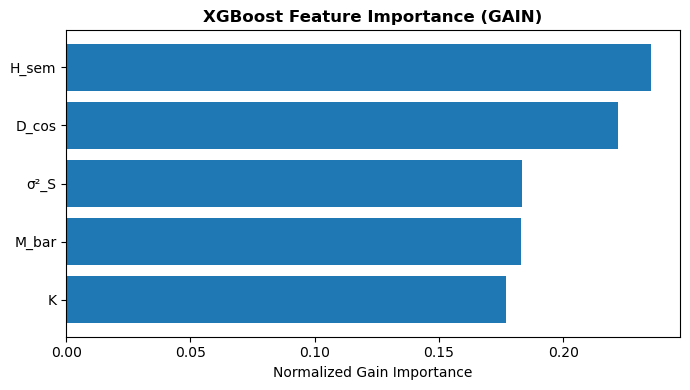

In [16]:
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

feature_names = ["H_sem", "D_cos", "M_bar", "K", "σ²_S"]

best_clf = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=3,
    learning_rate=0.08,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    eval_metric="logloss",
    random_state=CONFIG["random_seed"],
    verbosity=0
)

best_clf.fit(X_scaled, y)  # (tree models don't need scaling, but it's fine)

booster = best_clf.get_booster()
gain_dict = booster.get_score(importance_type="gain")  # {'f0':..., 'f1':...}

gain_vals = np.array([gain_dict.get(f"f{i}", 0.0) for i in range(len(feature_names))], dtype=float)
gain_vals = gain_vals / gain_vals.sum() if gain_vals.sum() > 0 else gain_vals

imp = pd.Series(gain_vals, index=feature_names).sort_values(ascending=True)

plt.figure(figsize=(7, 4))
plt.barh(imp.index, imp.values)
plt.xlabel("Normalized Gain Importance")
plt.title("XGBoost Feature Importance (GAIN)", fontweight="bold")
plt.tight_layout()
plt.show()

## Summary

In [45]:
print("=" * 55)
print("SUMMARY")
print("=" * 55)
print(f"  Dataset       : MMLU — {CONFIG['mmlu_subject']}")
print(f"  Questions     : {n}")
print(f"  Samples/Q     : {CONFIG['n_samples']}")
print(f"  Feature matrix: {X.shape}")
print(f"  Hallucination rate (question-level): {y.mean()*100:.1f}%")
print(f"  Best AUC-ROC  : {np.mean(auc_boot):.3f}  95% CI [{ci_lo:.3f}, {ci_hi:.3f}]")
print()
print("  Tips to improve results:")
print("     Increase n_questions to 500 for better statistics")
print("     Swap 'flan-t5-base' → 'flan-t5-large' for stronger generation")
print("     Try different MMLU subjects in CONFIG['mmlu_subject']")
print("=" * 55)

SUMMARY
  Dataset       : MMLU — high_school_geography
  Questions     : 198
  Samples/Q     : 100
  Feature matrix: (198, 5)
  Hallucination rate (question-level): 60.6%
  Best AUC-ROC  : 0.634  95% CI [0.525, 0.734]

  Tips to improve results:
     Increase n_questions to 500 for better statistics
     Swap 'flan-t5-base' → 'flan-t5-large' for stronger generation
     Try different MMLU subjects in CONFIG['mmlu_subject']
